In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pickle
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')

import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet)
# jupyter nbconvert --to script 'Indirect_NN.ipynb'


In [2]:
TRAINING_TYPE = "direct" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN" , 1) if TRAINING_TYPE=="direct" else ("indirect_NN_res" , 1)
 
    uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(N_iter-1) + ".dat", "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])






print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ 0.6475, -1.0036],
        [ 0.5519, -0.2328],
        [-3.9548,  0.5785],
        [ 0.5890, -0.7420],
        [-3.2909, -0.0858],
        [ 1.3760, -3.4489],
        [ 0.8681, -1.9223],
        [-5.2787,  1.4371],
        [-2.0881,  0.2618],
        [-1.2438, -0.0687]], requires_grad=True)
Parameter containing:
tensor([-0.5486, -1.0703,  1.2819, -2.7863,  0.7179,  0.8512, -0.7823,  2.1855,
        -0.5357, -0.6506], requires_grad=True)
Parameter containing:
tensor([[-1.6973, -0.9499, -0.2977,  1.4382, -0.1696,  3.5805, -1.3792,  0.1982,
          1.9758,  1.0389]], requires_grad=True)
Parameter containing:
tensor([1.1560], requires_grad=True)


# Direct test

In [3]:
N_y = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])

L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]

omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy


# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
    
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean

# TODO: clip and filter the data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)

../Utility/NeuralNet.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


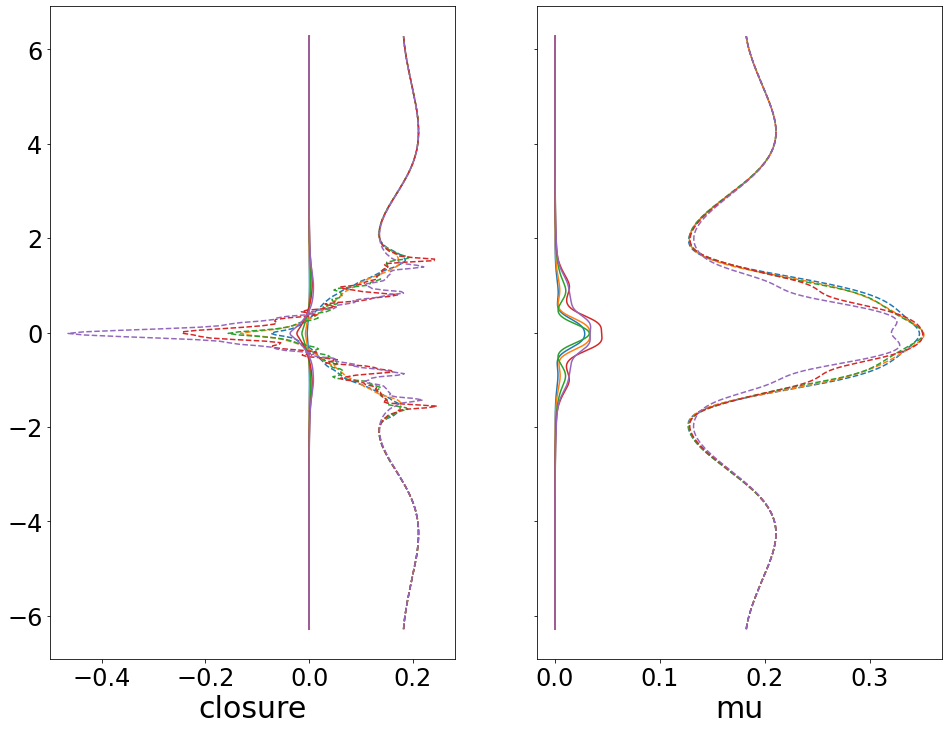

In [11]:
x_train = torch.from_numpy(np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T.astype(np.float32)) 
y_pred = NeuralNet.net_eval(x=x_train, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy, color="C"+str(i))
    ax[0].plot(y_pred[i,:]*dq_dy_mean[i,:], yy, "--", color="C"+str(i))
    
    ax[1].plot(mu_f[i,:], yy, color="C"+str(i))
    ax[1].plot(y_pred[i,:], yy, "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")

fig.savefig("Point-Jet-Training-" + TRAINING_TYPE + "Direct-Test.png")



# Plug-in test

In [ ]:
def point_jet(tau_inv, trained_net):

    beta = 1.0
    Nx = 384
    omega_jet = np.zeros(Nx)
    omega_jet[0:Nx//2] = 1.0
    omega_jet[Nx//2:Nx] = -1.0
    L = 4*np.pi
    yy = np.linspace(-L/2.0, L/2.0, Nx)
    q_jet = omega_jet + beta*yy



    tau = 1/float(tau_inv)
    data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
    dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
    closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
    w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
    q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

    _, Ny, Nt = q.shape
    q_mean_ref = np.mean(q[0, :, Nt//2:], axis=1)
    w_mean_ref = np.mean(w[0, :, Nt//2:], axis=1)


    nn_model = partial(NeuralNet.nn_viscosity, net=net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    model = lambda q, xx, res : nummodel(nn_model, q, xx, res)

    dt, Nt, save_every = 1.0e-4, 200000, 1000
    yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = L)
    q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)
    
    
    return yy, q_mean_ref, q_mean_pred

yy, q_mean_ref, q_mean_pred = point_jet( "0.08" , trained_net)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean_ref, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(q_mean_ref  - beta*yy, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
fig.savefig("Point-Jet-Training-" + TRAINING_TYPE + "Indirect-Test.png")

